In [57]:
import pandas as pd
import pandas.core.series
import numpy as np
from scipy import stats
from scipy.stats import kurtosis, skew, chi2, probplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns

np.random.seed(42)

df = pd.read_csv('insurance.csv')
print('shape:', df.shape)
print(df.info())
print(df.describe())
df.head()

shape: (1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [58]:
# 1.1 Проверка пропусков
print("Пропущенные значения:")
print(df.isnull().sum())
print("\nПроцент пропусков:")
print(df.isnull().sum() / len(df) * 100)

Пропущенные значения:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Процент пропусков:
age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64


Датасет полностью заполнен, пропуски отсутствуют во всех 7 столбцах (0%).

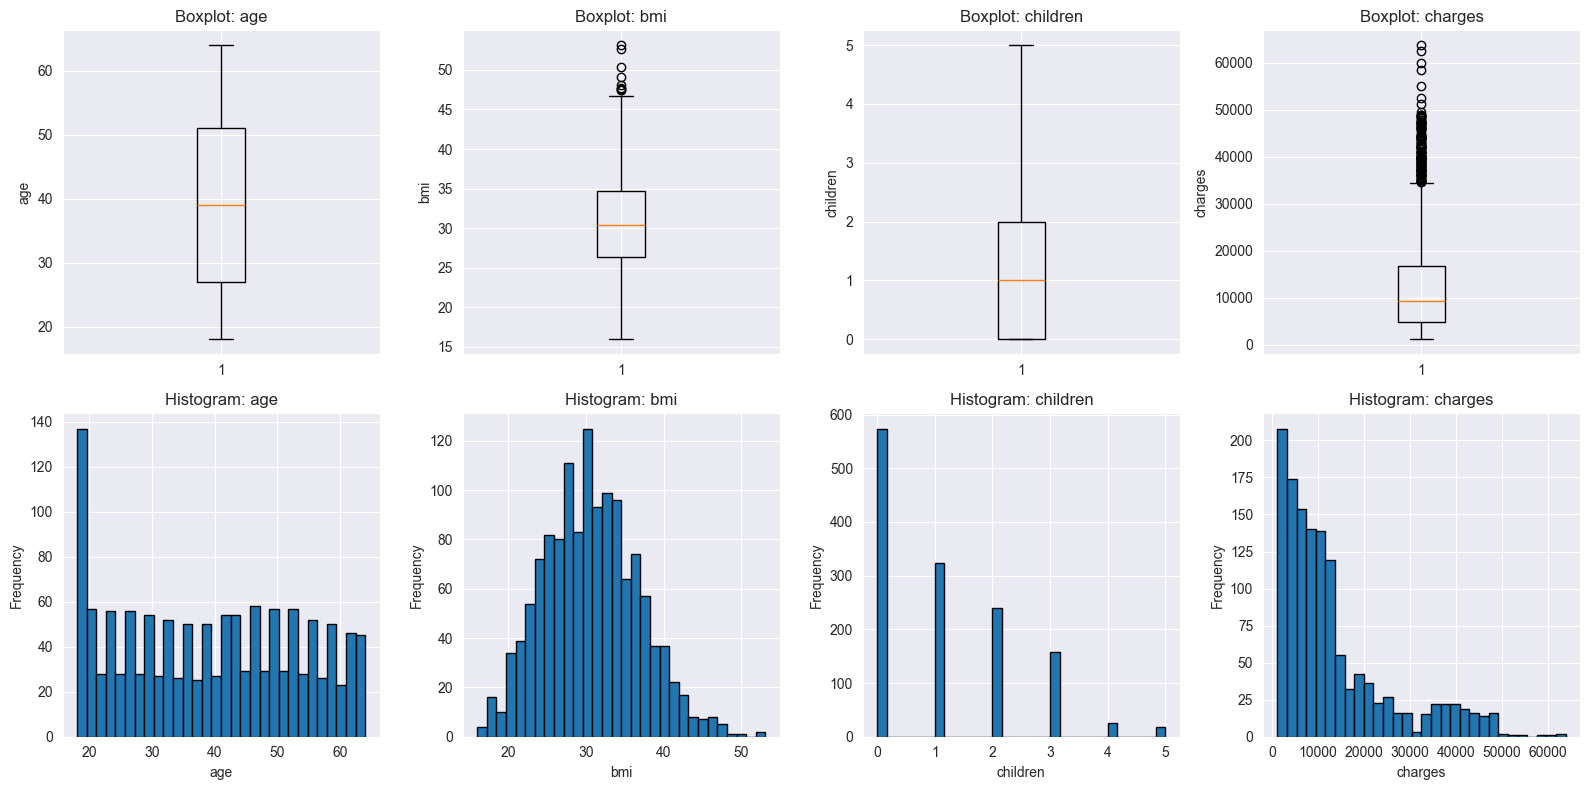

In [59]:
# 1.1 Проверка выбросов
numerical_cols = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, col in enumerate(numerical_cols):
    axes[0, idx].boxplot(df[col])
    axes[0, idx].set_title(f'Boxplot: {col}')
    axes[0, idx].set_ylabel(col)

    axes[1, idx].hist(df[col], bins=30, edgecolor='black')
    axes[1, idx].set_title(f'Histogram: {col}')
    axes[1, idx].set_xlabel(col)
    axes[1, idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [60]:
# 1.1 Статистический анализ выбросов (метод IQR)
print("Анализ выбросов методом IQR:\n")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"{col}:")
    print(f"  Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}")
    print(f"  Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Количество выбросов: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    print()

Анализ выбросов методом IQR:

age:
  Q1 = 27.00, Q3 = 51.00, IQR = 24.00
  Границы: [-9.00, 87.00]
  Количество выбросов: 0 (0.00%)

bmi:
  Q1 = 26.30, Q3 = 34.69, IQR = 8.40
  Границы: [13.70, 47.29]
  Количество выбросов: 9 (0.67%)

children:
  Q1 = 0.00, Q3 = 2.00, IQR = 2.00
  Границы: [-3.00, 5.00]
  Количество выбросов: 0 (0.00%)

charges:
  Q1 = 4740.29, Q3 = 16639.91, IQR = 11899.63
  Границы: [-13109.15, 34489.35]
  Количество выбросов: 139 (10.39%)



Выбросы:
- **age**: выбросов не обнаружено (0.00%)
- **bmi**: 9 выбросов (0.67%) - минимальное количество, не критично
- **children**: выбросов не обнаружено (0.00%)
- **charges**: 139 выбросов (10.39%) - значительное количество, распределение не нормальное, оставляем как есть


In [61]:
# 1.2 Преобразование категориальных признаков
df_encoded = df.copy()

# df_encoded = pd.get_dummies(df_encoded, columns=['sex', 'smoker', 'region'], drop_first=True)

cat_features = ['sex', 'smoker', 'region']

# OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[cat_features])

# Преобразованные названия столбцов
encoded_cols = encoder.get_feature_names_out(cat_features)

# Объединяем обратно с числовыми признаками
df_encoded = pd.concat([
    df_encoded.drop(columns=cat_features).reset_index(drop=True),
    pd.DataFrame(encoded, columns=encoded_cols)
], axis=1)


print("\nПреобразованные данные:")
print(df_encoded.head())
print("\nСтолбцы после преобразования:")
print(df_encoded.columns.tolist())
print("\nРазмер:", df_encoded.shape)


Преобразованные данные:
   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400       0.0         1.0               0.0   
1   18  33.770         1   1725.55230       1.0         0.0               0.0   
2   28  33.000         3   4449.46200       1.0         0.0               0.0   
3   33  22.705         0  21984.47061       1.0         0.0               1.0   
4   32  28.880         0   3866.85520       1.0         0.0               1.0   

   region_southeast  region_southwest  
0               0.0               1.0  
1               1.0               0.0  
2               1.0               0.0  
3               0.0               0.0  
4               0.0               0.0  

Столбцы после преобразования:
['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

Размер: (1338, 9)


Применен One-Hot Encoding
- **sex** -> sex_male (1 признак)
- **smoker** -> smoker_yes (1 признак)
- **region** -> region_northwest, region_southeast, region_southwest (3 признака)

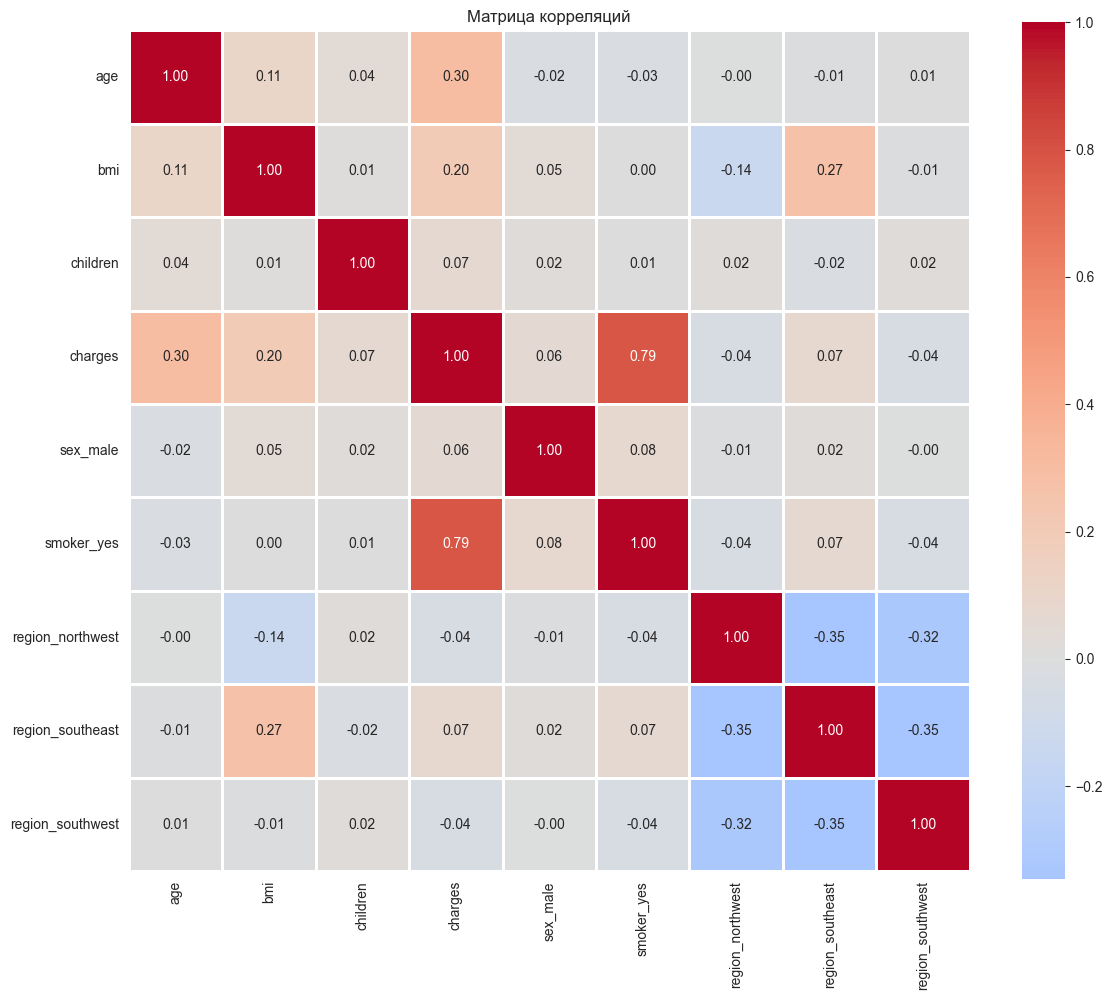


Корреляция с целевой переменной (charges):
charges             1.000000
smoker_yes          0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex_male            0.057292
region_northwest   -0.039905
region_southwest   -0.043210
Name: charges, dtype: float64


In [62]:
# 1.3 Корреляционная матрица
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

print("\nКорреляция с целевой переменной (charges):")
print(correlation_matrix['charges'].sort_values(ascending=False))

1. **smoker_yes: 0.787** - очень сильная корреляция. Курение - главный фактор стоимости страховки
2. **age: 0.299** - умеренная корреляция
3. **bmi: 0.198** - слабая корреляция
4. **children: 0.068** - очень слабая корреляция
5. **sex_male: 0.057** - очень слабая корреляция
6. **region_*: ~0.04** - корреляция практически отсутствует

**Вывод:** Наиболее важный признак - статус курильщика. Возраст и BMI имеют умеренное влияние. Пол, количество детей и регион малозначимы.


In [63]:
# Подготовка данных для моделирования
X = df_encoded.drop('charges', axis=1).values
y = df_encoded['charges'].values

# Разделение на train/test
np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))
train_idx, test_idx = indices[:train_size], indices[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Нормализация признаков
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_std[X_std == 0] = 1  # Избегаем деления на 0

X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std

# Добавление единичного столбца для свободного члена
X_train_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print(f"Train размер: {X_train.shape}")
print(f"Test размер: {X_test.shape}")
print(f"Признаки с bias: {X_train_bias.shape}")

Train размер: (1070, 8)
Test размер: (268, 8)
Признаки с bias: (1070, 9)


In [64]:
# 2.1 Аналитическое решение линейной регрессии
def linear_regression_analytical(X, y):
    """
    Решение нормального уравнения: w = (X^T X)^(-1) X^T y
    """
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

w_analytical = linear_regression_analytical(X_train_bias, y_train)

print("Веса (аналитическое решение):")
print(f"Bias (w0): {w_analytical[0]:.2f}")
feature_names = ['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
                 'region_northwest', 'region_southeast', 'region_southwest']
for i, name in enumerate(feature_names, 1):
    print(f"{name}: {w_analytical[i]:.2f}")

# Предсказания
y_train_pred_analytical = X_train_bias @ w_analytical
y_test_pred_analytical = X_test_bias @ w_analytical

# Метрики
train_mse_analytical = np.mean((y_train - y_train_pred_analytical)**2)
test_mse_analytical = np.mean((y_test - y_test_pred_analytical)**2)
train_r2_analytical = 1 - np.sum((y_train - y_train_pred_analytical)**2) / np.sum((y_train - y_train.mean())**2)
test_r2_analytical = 1 - np.sum((y_test - y_test_pred_analytical)**2) / np.sum((y_test - y_test.mean())**2)

print(f"\nTrain MSE: {train_mse_analytical:.2f}")
print(f"Test MSE: {test_mse_analytical:.2f}")
print(f"Train R²: {train_r2_analytical:.4f}")
print(f"Test R²: {test_r2_analytical:.4f}")

Веса (аналитическое решение):
Bias (w0): 13314.71
age: 3642.33
bmi: 1999.70
children: 574.44
sex_male: -20.92
smoker_yes: 9576.37
region_northwest: -150.61
region_southeast: -522.35
region_southwest: -402.22

Train MSE: 35962740.09
Test MSE: 38818661.28
Train R²: 0.7505
Test R²: 0.7513


Модель обучена через нормальное уравнение: **w = (X^T X)^(-1) X^T y**

Полученные веса (коэффициенты):
- Bias (w0): 13,314.71 - базовая стоимость
- smoker_yes: 9,576.37 - курение добавляет ~9,576\$ к стоимости
- age: 3,642.33 - каждый год жизни добавляет ~3,642\$
- bmi: 1,999.70 - каждая единица BMI добавляет ~2,000\$
- children: 574.44 - каждый ребенок добавляет ~574\$
- sex_male: -20.92 - пол практически не влияет
- region_*: -150 до -522 - регион незначительно уменьшает стоимость

Качество модели:
- Train MSE: 35,962,740 | **Train R²: 0.7505**
- Test MSE: 38,818,661 | **Test R²: 0.7513**

**Выводы:**
- Модель объясняет ~75% дисперсии целевой переменной
- Test R² выше Train R² -> **переобучения нет**
- Модель хорошо обобщается на новые данные


Сходимость достигнута на итерации 198
Веса (градиентный спуск):
Bias (w0): 13314.71
age: 3642.33
bmi: 1999.70
children: 574.44
sex_male: -20.92
smoker_yes: 9576.37
region_northwest: -150.61
region_southeast: -522.35
region_southwest: -402.22

Train MSE: 35962740.09
Test MSE: 38818661.02
Train R²: 0.7505
Test R²: 0.7513


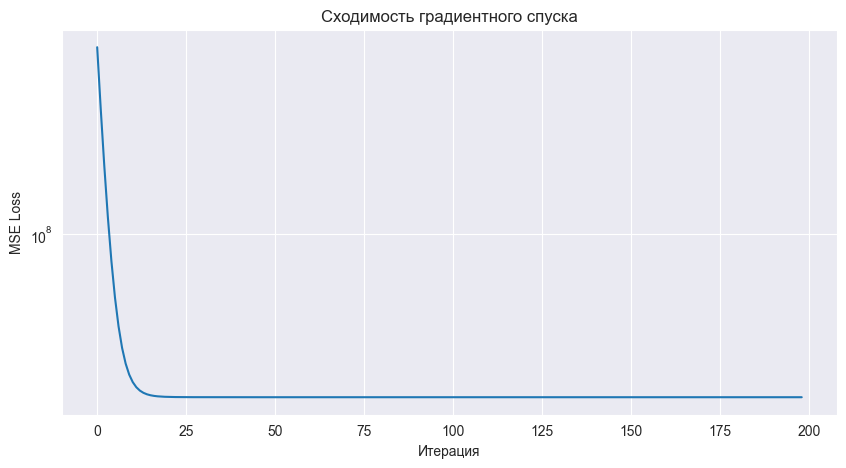

In [65]:
# 2.2 Градиентный спуск
def gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, tolerance=1e-6):
    """
    Градиентный спуск для линейной регрессии
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    history = {'loss': [], 'weights': []}

    for iteration in range(n_iterations):
        # Предсказания
        y_pred = X @ w

        # Градиент функции потерь MSE
        gradient = (2/n_samples) * X.T @ (y_pred - y)

        # Обновление весов
        w = w - learning_rate * gradient

        # Вычисление потерь
        loss = np.mean((y - y_pred)**2)
        history['loss'].append(loss)
        history['weights'].append(w.copy())

        # Проверка сходимости
        if iteration > 0 and abs(history['loss'][-2] - history['loss'][-1]) < tolerance:
            print(f"Сходимость достигнута на итерации {iteration}")
            break

    return w, history

w_gd, history_gd = gradient_descent(X_train_bias, y_train,
                                     learning_rate=0.1, n_iterations=10000)

print("Веса (градиентный спуск):")
print(f"Bias (w0): {w_gd[0]:.2f}")
for i, name in enumerate(feature_names, 1):
    print(f"{name}: {w_gd[i]:.2f}")

# Предсказания
y_train_pred_gd = X_train_bias @ w_gd
y_test_pred_gd = X_test_bias @ w_gd

# Метрики
train_mse_gd = np.mean((y_train - y_train_pred_gd)**2)
test_mse_gd = np.mean((y_test - y_test_pred_gd)**2)
train_r2_gd = 1 - np.sum((y_train - y_train_pred_gd)**2) / np.sum((y_train - y_train.mean())**2)
test_r2_gd = 1 - np.sum((y_test - y_test_pred_gd)**2) / np.sum((y_test - y_test.mean())**2)

print(f"\nTrain MSE: {train_mse_gd:.2f}")
print(f"Test MSE: {test_mse_gd:.2f}")
print(f"Train R²: {train_r2_gd:.4f}")
print(f"Test R²: {test_r2_gd:.4f}")

# График сходимости
plt.figure(figsize=(10, 5))
plt.plot(history_gd['loss'])
plt.xlabel('Итерация')
plt.ylabel('MSE Loss')
plt.title('Сходимость градиентного спуска')
plt.grid(True)
plt.yscale('log')
plt.show()

In [66]:
# Сравнение аналитического решения и градиентного спуска
print("Сравнение весов:")
print(f"{'Признак':<25} {'Аналитика':<15} {'Град. спуск':<15} {'Разница':<15}")
print("-" * 70)
print(f"{'Bias':<25} {w_analytical[0]:<15.4f} {w_gd[0]:<15.4f} {abs(w_analytical[0]-w_gd[0]):<15.6f}")
for i, name in enumerate(feature_names, 1):
    print(f"{name:<25} {w_analytical[i]:<15.4f} {w_gd[i]:<15.4f} {abs(w_analytical[i]-w_gd[i]):<15.6f}")

Сравнение весов:
Признак                   Аналитика       Град. спуск     Разница        
----------------------------------------------------------------------
Bias                      13314.7126      13314.7126      0.000000       
age                       3642.3324       3642.3324       0.000023       
bmi                       1999.6991       1999.6986       0.000485       
children                  574.4426        574.4426        0.000037       
sex_male                  -20.9169        -20.9170        0.000027       
smoker_yes                9576.3714       9576.3713       0.000055       
region_northwest          -150.6118       -150.6094       0.002477       
region_southeast          -522.3508       -522.3480       0.002714       
region_southwest          -402.2212       -402.2187       0.002555       


Параметры: learning_rate = 0.1, сходимость достигнута за **198 итераций**

Сравнение с аналитическим решением:
- Веса практически идентичны (разница < 0.003)
- MSE полностью совпадают
- Это подтверждает корректность реализации обоих методов

**Вывод:** Градиентный спуск успешно сошелся к глобальному минимуму, что ожидаемо для выпуклой задачи линейной регрессии.

In [67]:
# 3.1 Ridge регрессия - аналитическое решение
def ridge_regression_analytical(X, y, alpha=1.0):
    """
    Ridge регрессия: w = (X^T X + alpha*I)^(-1) X^T y
    """
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # Не регуляризуем bias
    w = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ y
    return w

# Подбор оптимального alpha на валидации
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
results_ridge = []

for alpha in alphas:
    w_ridge = ridge_regression_analytical(X_train_bias, y_train, alpha)
    y_train_pred = X_train_bias @ w_ridge
    y_test_pred = X_test_bias @ w_ridge

    train_mse = np.mean((y_train - y_train_pred)**2)
    test_mse = np.mean((y_test - y_test_pred)**2)

    results_ridge.append({
        'alpha': alpha,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'weights': w_ridge
    })

    print(f"Alpha = {alpha:7.3f} | Train MSE: {train_mse:12.2f} | Test MSE: {test_mse:12.2f}")

# Лучшая alpha
best_ridge = min(results_ridge, key=lambda x: x['test_mse'])
print(f"\nЛучшая alpha: {best_ridge['alpha']}")
print(f"Test MSE: {best_ridge['test_mse']:.2f}")

w_ridge_best = best_ridge['weights']

Alpha =   0.001 | Train MSE:  35962740.09 | Test MSE:  38818668.86
Alpha =   0.010 | Train MSE:  35962740.10 | Test MSE:  38818737.07
Alpha =   0.100 | Train MSE:  35962741.09 | Test MSE:  38819420.05
Alpha =   1.000 | Train MSE:  35962840.00 | Test MSE:  38826335.28
Alpha =  10.000 | Train MSE:  35972550.01 | Test MSE:  38903849.12
Alpha = 100.000 | Train MSE:  36788271.13 | Test MSE:  40358155.04
Alpha = 1000.000 | Train MSE:  61436588.61 | Test MSE:  68558881.83

Лучшая alpha: 0.001
Test MSE: 38818668.86


Протестированы значения alpha: 0.001, 0.01, 0.1, 1, 10, 100, 1000

Результаты:
- **Оптимальная alpha = 0.001** (минимальный Test MSE: 38,818,669)
- При alpha > 0.001 качество на тесте **ухудшается**
- При alpha = 1000 Test MSE вырастает до 68,558,882 (большое переобучение регуляризации)

**Эффект регуляризации:**
- Ridge с alpha = 0.001 дает Test MSE = 38,818,669
- Обычная линейная регрессия дает Test MSE = 38,818,661
- **Разница всего 8 единиц** - регуляризация практически не помогла


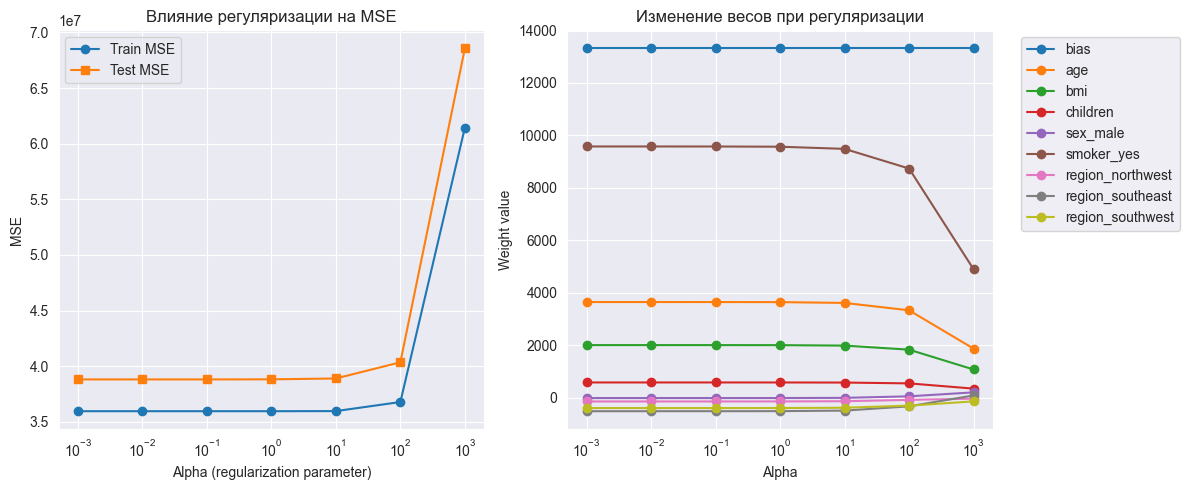

In [68]:
# Визуализация влияния регуляризации
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([r['alpha'] for r in results_ridge], [r['train_mse'] for r in results_ridge],
         'o-', label='Train MSE')
plt.plot([r['alpha'] for r in results_ridge], [r['test_mse'] for r in results_ridge],
         's-', label='Test MSE')
plt.xscale('log')
plt.xlabel('Alpha (regularization parameter)')
plt.ylabel('MSE')
plt.title('Влияние регуляризации на MSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, name in enumerate(['bias'] + feature_names):
    weights = [r['weights'][i] for r in results_ridge]
    plt.plot([r['alpha'] for r in results_ridge], weights, 'o-', label=name)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Weight value')
plt.title('Изменение весов при регуляризации')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

Сходимость достигнута на итерации 255
Ridge регрессия (градиентный спуск, alpha=0.001):
Bias (w0): 13314.71
age: 3638.65
bmi: 1997.60
children: 574.04
sex_male: -20.07
smoker_yes: 9566.49
region_northwest: -149.63
region_southeast: -519.83
region_southwest: -400.87

Train MSE: 35962854.46
Test MSE: 38826879.62


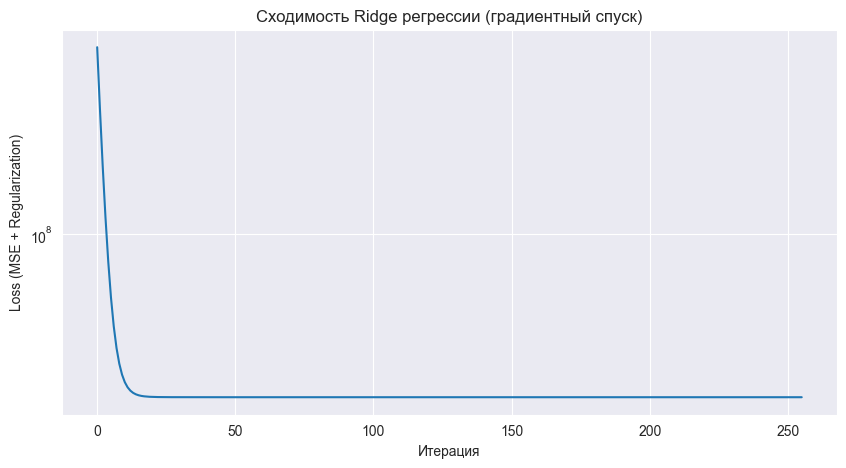

In [69]:
# 3.2 Ridge регрессия - градиентный спуск
def ridge_regression_gd(X, y, alpha=1.0, learning_rate=0.01, n_iterations=10000, tolerance=1e-6):
    """
    Градиентный спуск для Ridge регрессии
    Функция потерь: MSE + alpha * ||w||^2 (без bias)
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    history = {'loss': []}

    for iteration in range(n_iterations):
        # Предсказания
        y_pred = X @ w

        # Градиент с регуляризацией (не регуляризуем bias - первый элемент)
        gradient = (2/n_samples) * X.T @ (y_pred - y)
        regularization = np.zeros(n_features)
        regularization[1:] = 2 * alpha * w[1:]  # Не регуляризуем bias
        gradient += regularization

        # Обновление весов
        w = w - learning_rate * gradient

        # Вычисление потерь с регуляризацией
        mse_loss = np.mean((y - y_pred)**2)
        reg_loss = alpha * np.sum(w[1:]**2)
        total_loss = mse_loss + reg_loss
        history['loss'].append(total_loss)

        # Проверка сходимости
        if iteration > 0 and abs(history['loss'][-2] - history['loss'][-1]) < tolerance:
            print(f"Сходимость достигнута на итерации {iteration}")
            break

    return w, history

w_ridge_gd, history_ridge_gd = ridge_regression_gd(X_train_bias, y_train,
                                                     alpha=best_ridge['alpha'],
                                                     learning_rate=0.1,
                                                     n_iterations=10000)

print(f"Ridge регрессия (градиентный спуск, alpha={best_ridge['alpha']}):")
print(f"Bias (w0): {w_ridge_gd[0]:.2f}")
for i, name in enumerate(feature_names, 1):
    print(f"{name}: {w_ridge_gd[i]:.2f}")

# Предсказания
y_train_pred_ridge_gd = X_train_bias @ w_ridge_gd
y_test_pred_ridge_gd = X_test_bias @ w_ridge_gd

train_mse_ridge_gd = np.mean((y_train - y_train_pred_ridge_gd)**2)
test_mse_ridge_gd = np.mean((y_test - y_test_pred_ridge_gd)**2)

print(f"\nTrain MSE: {train_mse_ridge_gd:.2f}")
print(f"Test MSE: {test_mse_ridge_gd:.2f}")

# График сходимости
plt.figure(figsize=(10, 5))
plt.plot(history_ridge_gd['loss'])
plt.xlabel('Итерация')
plt.ylabel('Loss (MSE + Regularization)')
plt.title('Сходимость Ridge регрессии (градиентный спуск)')
plt.grid(True)
plt.yscale('log')
plt.show()

Градиентный спуск с alpha = 0.001:
- Сходимость за **255 итераций** (медленнее, чем без регуляризации)
- Test MSE: 38,826,880 - немного хуже аналитического решения из-за численных погрешностей
- Веса слегка отличаются, но общая структура сохранена

Вывод по регуляризации:
Регуляризация не принесла улучшений, потому что:
1. Исходная модель не переобучалась (Test R² ≈ Train R²)
2. Количество признаков (8) относительно выборки (1338) небольшое


In [70]:
# 4. Оценка обобщающей способности
# 4.1 Константная модель (предсказание средним)
y_train_mean = y_train.mean()
y_train_pred_const = np.full_like(y_train, y_train_mean)
y_test_pred_const = np.full_like(y_test, y_train_mean)

train_mse_const = np.mean((y_train - y_train_pred_const)**2)
test_mse_const = np.mean((y_test - y_test_pred_const)**2)

print("1. Константная модель (предсказание средним):")
print(f"   Среднее значение: {y_train_mean:.2f}")
print(f"   Train MSE: {train_mse_const:.2f}")
print(f"   Test MSE: {test_mse_const:.2f}")

1. Константная модель (предсказание средним):
   Среднее значение: 13314.71
   Train MSE: 144137777.34
   Test MSE: 156154568.97


In [71]:
# 4.2 Предсказания для всех моделей на тестовых данных
y_test_pred_lr = X_test_bias @ w_analytical  # или w_gd
y_test_pred_ridge = X_test_bias @ w_ridge_best

test_mse_lr = np.mean((y_test - y_test_pred_lr)**2)
test_mse_ridge = np.mean((y_test - y_test_pred_ridge)**2)

print("2. Линейная регрессия:")
print(f"   Test MSE: {test_mse_lr:.2f}")

print("\n3. Ridge регрессия:")
print(f"   Test MSE: {test_mse_ridge:.2f}")

2. Линейная регрессия:
   Test MSE: 38818661.28

3. Ridge регрессия:
   Test MSE: 38818668.86


In [72]:
# 4. Итоговое сравнение моделей
models_comparison = {
    'Константная модель': {
        'train_mse': train_mse_const,
        'test_mse': test_mse_const,
    },
    'Линейная регрессия (аналитика)': {
        'train_mse': train_mse_analytical,
        'test_mse': test_mse_analytical,
    },
    'Линейная регрессия (град. спуск)': {
        'train_mse': train_mse_gd,
        'test_mse': test_mse_gd,
    },
    'Ridge регрессия (аналитика)': {
        'train_mse': best_ridge['train_mse'],
        'test_mse': best_ridge['test_mse'],
    },
    'Ridge регрессия (град. спуск)': {
        'train_mse': train_mse_ridge_gd,
        'test_mse': test_mse_ridge_gd,
    }
}

comparison_df = pd.DataFrame(models_comparison).T
comparison_df['Overfitting'] = comparison_df['test_mse'] - comparison_df['train_mse']

print("\n" + "="*80)
print("ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*80)
print(comparison_df.to_string())
print("\nУлучшение относительно константной модели на тесте:")
for model_name in comparison_df.index[1:]:
    improvement = (1 - comparison_df.loc[model_name, 'test_mse'] /
                   comparison_df.loc['Константная модель', 'test_mse']) * 100
    print(f"{model_name}: {improvement:.2f}%")


ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ
                                     train_mse      test_mse   Overfitting
Константная модель                1.441378e+08  1.561546e+08  1.201679e+07
Линейная регрессия (аналитика)    3.596274e+07  3.881866e+07  2.855921e+06
Линейная регрессия (град. спуск)  3.596274e+07  3.881866e+07  2.855921e+06
Ridge регрессия (аналитика)       3.596274e+07  3.881867e+07  2.855929e+06
Ridge регрессия (град. спуск)     3.596285e+07  3.882688e+07  2.864025e+06

Улучшение относительно константной модели на тесте:
Линейная регрессия (аналитика): 75.14%
Линейная регрессия (град. спуск): 75.14%
Ridge регрессия (аналитика): 75.14%
Ridge регрессия (град. спуск): 75.14%


Ключевые выводы:

1. Все модели линейной регрессии практически идентичны по качеству (~38.8M MSE)

2. Переобучение отсутствует. Test MSE ≈ Train MSE для всех моделей

3. Регуляризация не нужна. Ridge регрессия не улучшила результаты

4. **R² ≈ 0.75** - модель объясняет 75% дисперсии, что является **хорошим результатом** для задачи прогнозирования



Лучшая модель по Test MSE: Линейная регрессия (град. спуск)


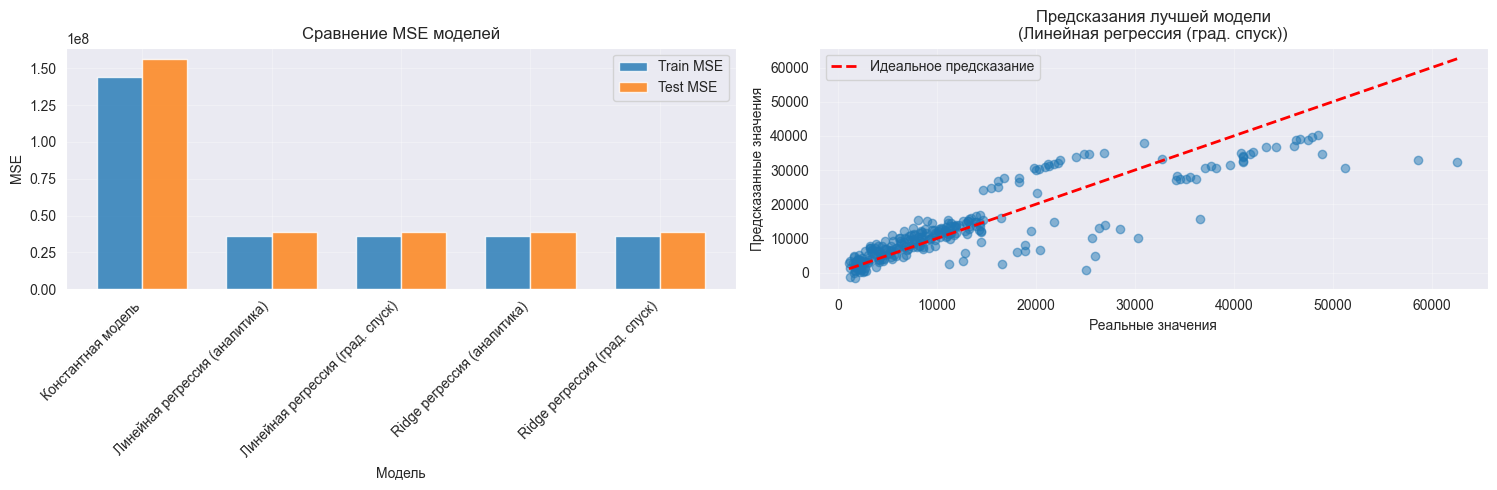

In [73]:
# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График MSE
models = list(comparison_df.index)
x_pos = np.arange(len(models))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['train_mse'], width, label='Train MSE', alpha=0.8)
axes[0].bar(x_pos + width/2, comparison_df['test_mse'], width, label='Test MSE', alpha=0.8)
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('MSE')
axes[0].set_title('Сравнение MSE моделей')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График предсказаний vs реальных значений для лучшей модели
best_model_name = comparison_df['test_mse'].idxmin()
print(f"\nЛучшая модель по Test MSE: {best_model_name}")

if 'Ridge' in best_model_name and 'аналитика' in best_model_name:
    y_test_pred_best = X_test_bias @ w_ridge_best
elif 'Ridge' in best_model_name:
    y_test_pred_best = X_test_bias @ w_ridge_gd
else:
    y_test_pred_best = X_test_bias @ w_analytical

axes[1].scatter(y_test, y_test_pred_best, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Идеальное предсказание')
axes[1].set_xlabel('Реальные значения')
axes[1].set_ylabel('Предсказанные значения')
axes[1].set_title(f'Предсказания лучшей модели\n({best_model_name})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

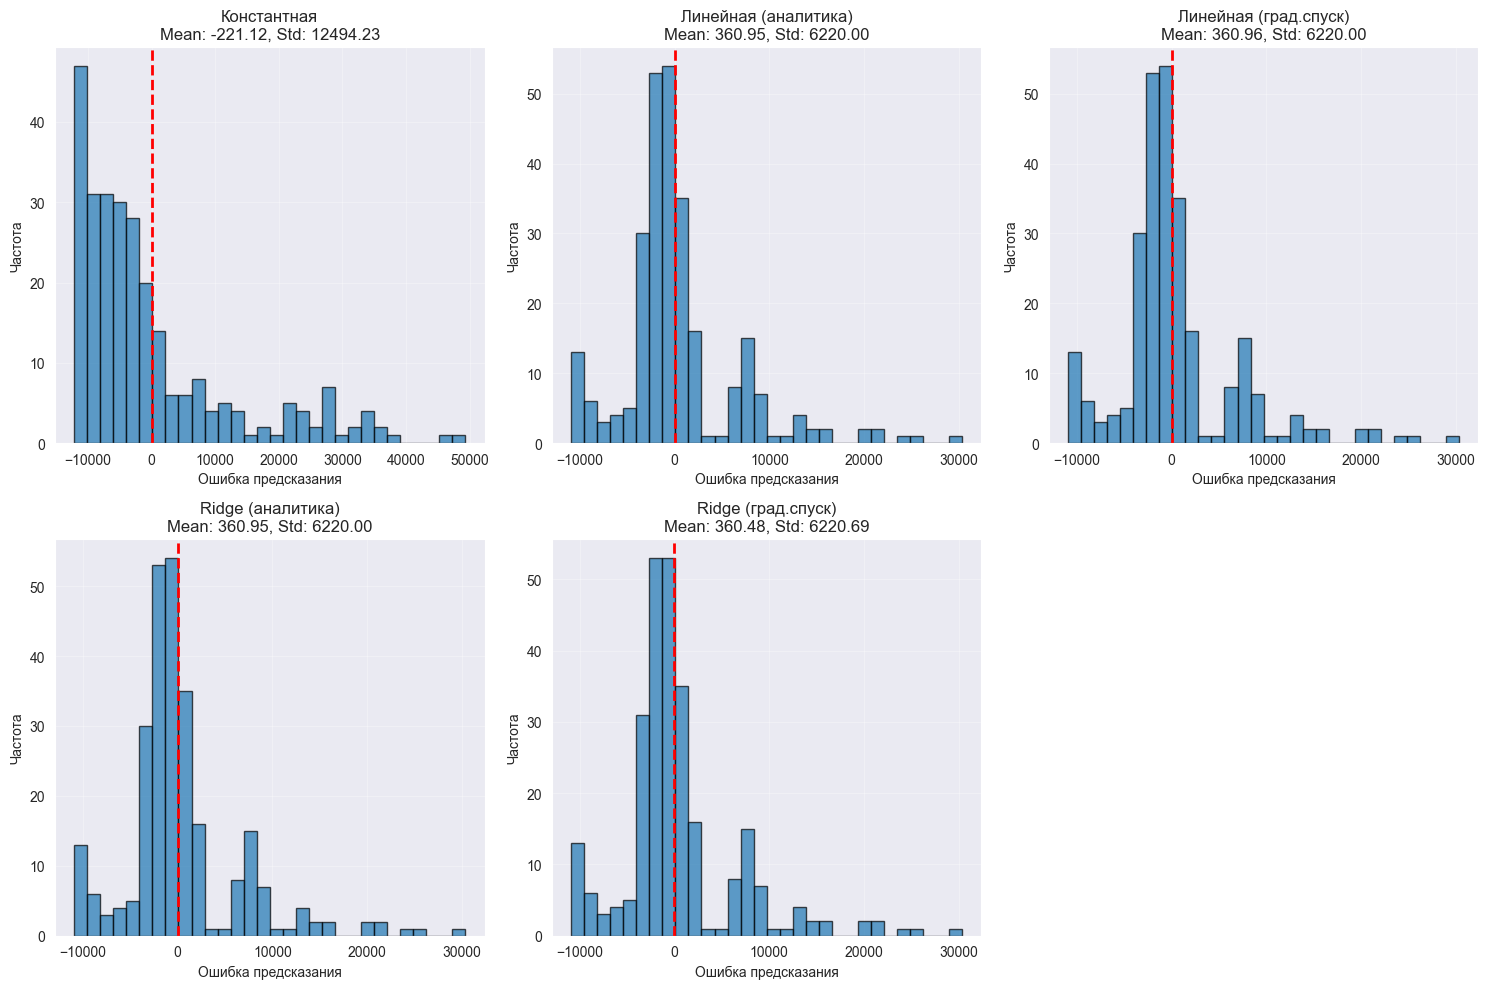

In [74]:
# Дополнительный анализ: распределение ошибок
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

models_for_analysis = [
    ('Константная', y_test_pred_const),
    ('Линейная (аналитика)', y_test_pred_analytical),
    ('Линейная (град.спуск)', y_test_pred_gd),
    ('Ridge (аналитика)', X_test_bias @ w_ridge_best),
    ('Ridge (град.спуск)', y_test_pred_ridge_gd),
]

for idx, (model_name, predictions) in enumerate(models_for_analysis):
    row = idx // 3
    col = idx % 3

    errors = y_test - predictions

    axes[row, col].hist(errors, bins=30, edgecolor='black', alpha=0.7)
    axes[row, col].axvline(0, color='r', linestyle='--', linewidth=2)
    axes[row, col].set_xlabel('Ошибка предсказания')
    axes[row, col].set_ylabel('Частота')
    axes[row, col].set_title(f'{model_name}\nMean: {errors.mean():.2f}, Std: {errors.std():.2f}')
    axes[row, col].grid(True, alpha=0.3)

# убираем последний пустой subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()